In [104]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# RUN MODELS

### This notebook serves as a one stop shop for our models. Get all evaluation metrics in one place. 

# Model Creation

Current Regression Models: XGBoost and RandomForestRegressor
Past Regression Models: LinearRegression, KNN,

In [758]:
train=pd.read_csv("../data/TrainingData/train.csv")
test=pd.read_csv("../data/TestData/test.csv")
val=pd.read_csv("../data/ValidationData/val.csv")

In [784]:
predict = pd.read_csv("../data/PredictionData/predict_set.csv")
predict["actual"] = ["Unknown" for i in np.arange(len(predict["actual"]))]
predict.dropna(inplace=True)
predict

,YEAR FORECAST MADE,YEAR BEING FORECAST,FORECASTER_CONF,INDICATOR,actual,pred_average,pred_var,banana,beef,bread,chicken,eggs,electricity,flour,iceCream,unleadedGasoline
1,2019,2022,0.288582,RealGDP,Unknown,1.8000,1.010000,0.576000,3.761333,1.272333,1.475667,1.551667,0.135333,0.442333,4.894667,2.402000
6,2019,2022,0.335406,RealGDP,Unknown,1.1900,0.913900,0.576000,3.761333,1.272333,1.475667,1.551667,0.135333,0.442333,4.894667,2.402000
7,2019,2022,0.306127,RealGDP,Unknown,1.8400,0.904400,0.576000,3.761333,1.272333,1.475667,1.551667,0.135333,0.442333,4.894667,2.402000
9,2019,2022,0.256955,RealGDP,Unknown,2.2400,1.652400,0.576000,3.761333,1.272333,1.475667,1.551667,0.135333,0.442333,4.894667,2.402000
10,2019,2022,0.256112,RealGDP,Unknown,2.3200,1.747600,0.576000,3.761333,1.272333,1.475667,1.551667,0.135333,0.442333,4.894667,2.402000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,2021,2024,0.324173,Unemployment,Unknown,5.2650,0.514775,0.599667,4.184667,1.510333,1.491667,1.629000,0.140333,0.410667,4.849667,2.988333
1499,2021,2024,0.288279,Unemployment,Unknown,5.1875,0.199219,0.599667,4.184667,1.510333,1.491667,1.629000,0.140333,0.410667,4.849667,2.988333
1502,2021,2024,0.306512,Unemployment,Unknown,5.5140,0.578179,0.599667,4.184667,1.510333,1.491667,1.629000,0.140333,0.410667,4.849667,2.988333
1504,2021,2024,0.207143,Unemployment,Unknown,5.1250,0.203125,0.599667,4.184667,1.510333,1.491667,1.629000,0.140333,0.410667,4.849667,2.988333


In [785]:
def MeasureSplit(df,measure):
    return df[df["INDICATOR"]==measure].drop(columns = ["actual","INDICATOR","YEAR BEING FORECAST","YEAR FORECAST MADE"]),df[df["INDICATOR"]==measure]["actual"]

In [762]:
def prepare_predictions():
    return

In [842]:
class RegressionModel:
    measures = ["Unemployment","RealGDP","Core CPI","Core PCE"]
    RF_params = {"n_estimators":np.arange(100,300,20)}
    Xgboost_params = {'max_depth':np.arange(2,10),'n_estimators': np.arange(60,200,40),"learning_rate":[0.01,0.05,0.1]}
    def __init__(self,name,model,optimize=False):
        self.years = None
        self.name = name
        self.model = model
        self.fitted_models = dict.fromkeys(self.measures,None)
        self.best_models = dict.fromkeys(self.measures,None)
        
        self.rmse_scores = []
        self.optimized_rmse_scores = []
        self.test_rmse_scores = []
        
        self.optimized_r2_scores = []
        self.r2_scores = []
        self.test_r2_scores = []
        
        self.optimized=False
        
        self.train_models()
        if optimize:
            if str(type(self.model))=="<class 'sklearn.ensemble._forest.RandomForestRegressor'>":
                self.perform_gridsearch(self.RF_params)
            elif str(type(self.model)) == "<class 'xgboost.sklearn.XGBRegressor'>":
                self.perform_gridsearch(self.Xgboost_params)
        
    def train_models(self):
        for measure in self.measures:
            X_train,y_train = MeasureSplit(train,measure)
            model = clone(self.model)
            model.fit(X_train,y_train)
            self.fitted_models[measure] = model
        self.store_scores("Initial")  
        return print("initial models fitted")    
        
    def store_scores(self,score_type,dataset=val):
        self.clear_scores(score_type)
        rmse,r2 = self.get_score_type(score_type)
        models = self.get_model_type(score_type)
        for measure in self.measures:
            X_test,y_test = MeasureSplit(dataset,measure)
            predictions = self.get_predictions(models[measure],measure,dataset) 
            rmse.append(np.sqrt(np.mean((y_test-predictions)**2)))
            r2.append(r2_score(y_test,predictions))
        return 
    
    def clear_scores(self,score_type):
        rmse,r2 = self.get_score_type(score_type)
        rmse = []
        r2 = []
    
    def get_predictions(self,model,variable_name,dataset=val):
        assert variable_name in self.measures
        #returns predictions for specified measure
        X_test,y_test = MeasureSplit(dataset,variable_name)
        return model.predict(X_test)
    
    def get_score_type(self,score_type):
        if score_type=="Initial":
            rmse = self.rmse_scores
            r2 = self.r2_scores
        elif score_type == "Optimized":
            rmse = self.optimized_rmse_scores
            r2 = self.optimized_r2_scores
        elif score_type == "Test":
            rmse = self.test_rmse_scores
            r2 = self.test_r2_scores
        else: 
            print("Choose valid score type.")
        return rmse,r2
    
    def get_model_type(self,model_type):
        if model_type=="Initial":
            models = self.fitted_models
        elif model_type == "Optimized":
            models = self.best_models
        elif model_type == "Test":
            if self.optimized:
                models = self.best_models
            else:
                models = self.fitted_models
        else: 
            print("Choose valid model type.")
        return models
    
    def plot_scores(self,score_type):
        rmse,r2 = self.get_score_type(score_type)
        fig,axes = plt.subplots(2,1,figsize=(10,20))
        for i,score,s in zip([0,1],['RMSE Scores','R^2 Scores'],[rmse,r2]):
            sns.barplot(x=self.measures,y=s,ax=axes[i])
            axes[i].set_title(score)
            axes[i].set_xlabel("Economic Measures")
            axes[i].set_ylabel("Score")
        return plt.show()
            
    def run_test(self):
        self.store_scores("Test",test)
        return
    
   
    
    def annual_performance(self, model_type, variable_name,dataset=val, plot=True):
        assert variable_name in self.measures
        model = self.get_model_type(model_type)[variable_name]
        preds = self.get_predictions(model,variable_name,dataset)
        actuals = dataset[dataset["INDICATOR"]==variable_name]['actual']
        spf_preds = dataset[dataset["INDICATOR"]==variable_name]['pred_average']
        years = dataset[dataset["INDICATOR"]==variable_name]['YEAR BEING FORECAST']
        print(actuals)
        frame = pd.DataFrame({"Actual": actuals, "SPF": spf_preds, "Model": preds, "Year": years})
        grouped = frame.groupby("Year").mean()
        self.years = years
        if plot == True:
            fig,ax = plt.subplots(1,1,figsize=(25,10))
            #plt.title("Historical Model Performance predicting "+variable_name,size=30)
            
            plt.plot(grouped['Actual'],linewidth=4)
            plt.plot(grouped['SPF'],linewidth=4)
            plt.plot(grouped['Model'],linewidth=4)
            labels = ["Actual", "SPF", "Model"]
            #plt.xlabel("Year",size=30)
            #plt.ylabel("Percent Change", size=30)
            plt.legend(labels,loc="lower left",prop={'size': 30})
            ax.tick_params(axis='both', which='major', labelsize=30)
            ax.tick_params(axis='both', which='minor', labelsize=30)
            plt.show()
            
        return grouped
    
    def perform_gridsearch(self,parameters):
        
        def find_optimal_model(variable_name):
            X_train,y_train = MeasureSplit(train,variable_name)
            gridsearch = GridSearchCV(estimator=self.model,param_grid = parameters,scoring='neg_root_mean_squared_error',n_jobs=5,cv=5,verbose=True)
            gridsearch.fit(X_train,y_train)
            return gridsearch.best_estimator_
        
        for measure in self.measures:    
            self.best_models[measure]=find_optimal_model(measure)
        self.optimized=True
        self.store_scores("Optimized")
        return
    
    def get_feature_importance(self,model_type,variable_name):
        assert variable_name in self.measures
        X_train,y_train = MeasureSplit(train,variable_name)
        model= self.get_model_type(model_type)[variable_name].fit(X_train,y_train)
        fig,axs = plt.subplots(1,1,figsize=(25,10))
        sorted_scores = model.feature_importances_.argsort()
        sns.barplot(x=X_train.columns[sorted_scores],y=model.feature_importances_[sorted_scores])
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Feature Importance for "+self.name + " predicting: "+variable_name ,size=30);
    def create_results(self,model_type,dataset=val):
        models = self.get_model_type(model_type)
        data = {}
        for measure in self.measures:
            data[measure] = self.get_predictions(models[measure],measure,dataset)
        return pd.DataFrame(dict([ (self.name+" "+k,pd.Series(v)) for k,v in data.items()]))
    
    def future_predictions(self,model_type,variable_name):
        new_predictions = self.get_predictions(self.get_model_type(model_type)[variable_name],variable_name,predict)
        frame = pd.DataFrame({ variable_name+" Prediction": new_predictions, "Year": predict[predict["INDICATOR"]==variable_name]["YEAR BEING FORECAST"]})
        grouped = frame.groupby("Year").mean()
        return grouped


In [838]:
rf = RegressionModel("RandomForest", RandomForestRegressor(),True)

initial models fitted
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [777]:
rf.rmse_scores

[0.9244951382054163,
 0.9944794694023015,
 0.31779862583774626,
 0.22415357832741248]

In [691]:
rf.run_test()

In [712]:
rf.test_rmse_scores

[]

In [778]:
rf.test_r2_scores

[]

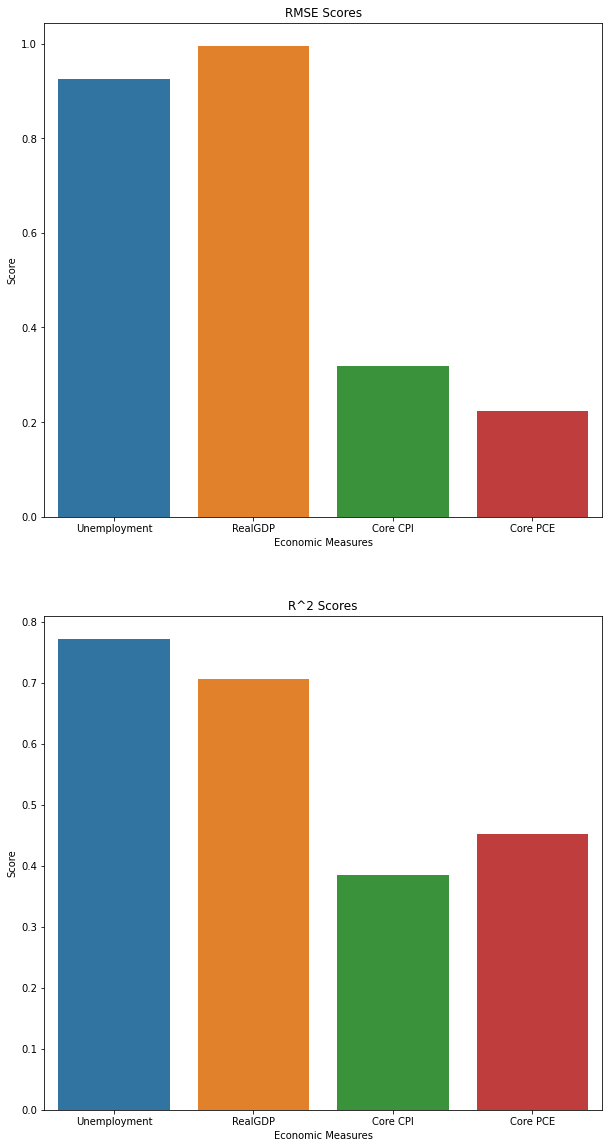

In [779]:
rf.plot_scores("Initial")

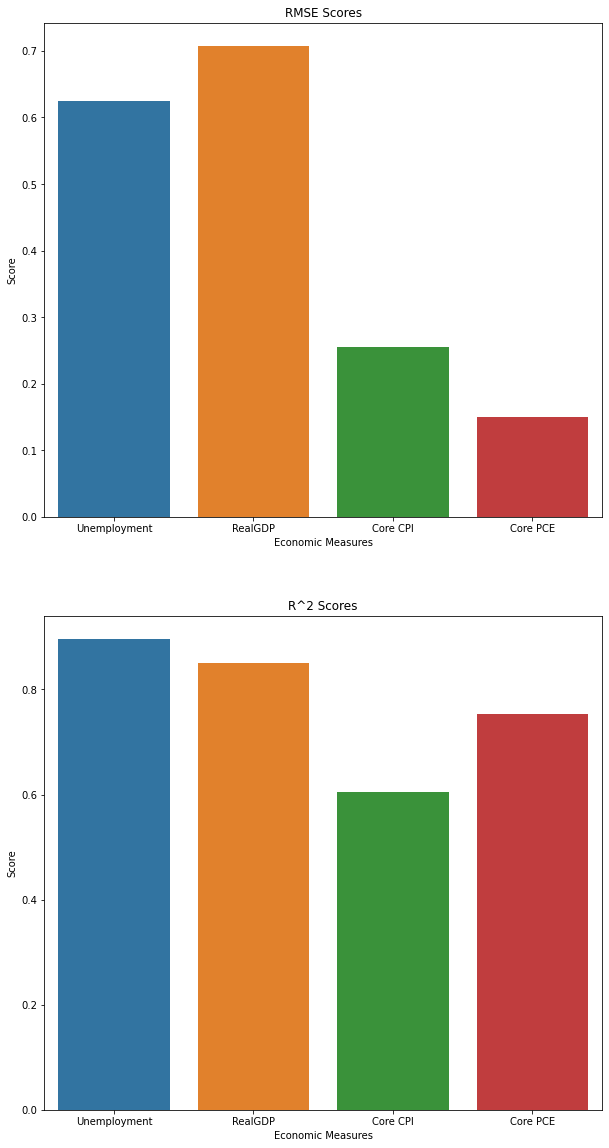

In [714]:
rf.plot_scores("Optimized")

In [833]:
rf.future_predictions("Optimized","Core PCE")

,Core PCE Prediction
Year,
2022,1.443443


1       0.12219
2       4.48139
4      -2.59989
5       2.68421
9      -3.40459
         ...   
4625    1.66747
4627    2.28069
4630    2.75179
4631    3.77257
4633    3.48322
Name: actual, Length: 2115, dtype: float64


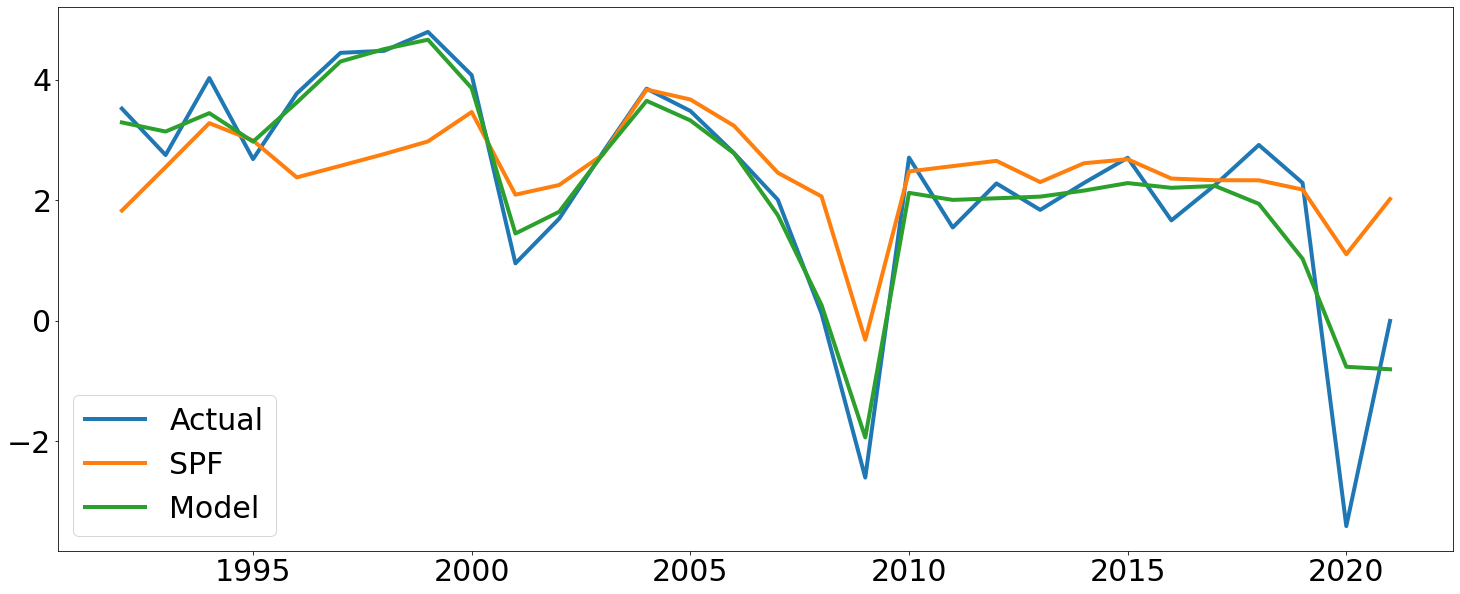

,Actual,SPF,Model
Year,,,
1992,3.52244,1.829429,3.292782
1993,2.75179,2.550978,3.141431
1994,4.02879,3.280692,3.446766
1995,2.68421,2.992412,2.973582
1996,3.77257,2.380820,3.624223
1997,4.44717,2.573348,4.303806
1998,4.48139,2.768265,4.510103
1999,4.79450,2.977600,4.665283
2000,4.07716,3.465722,3.860819


In [829]:
rf.annual_performance("Initial","RealGDP")

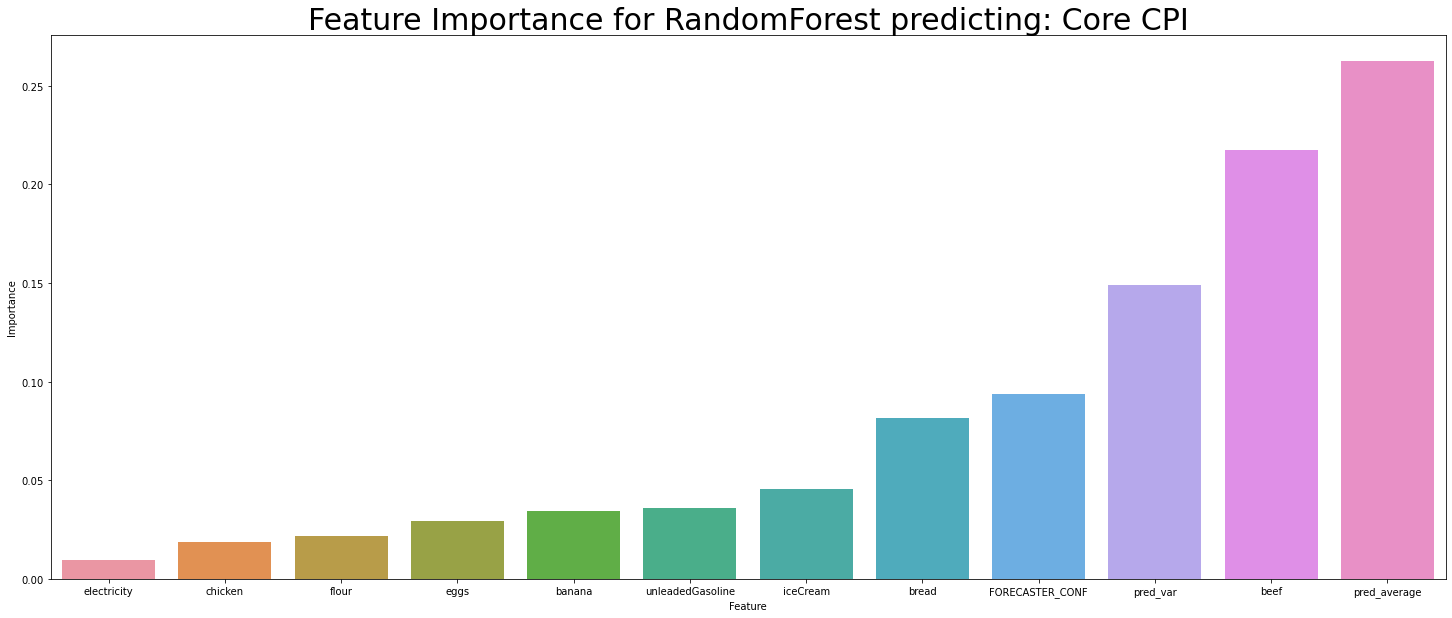

In [781]:
rf.get_feature_importance("Initial","Core CPI")

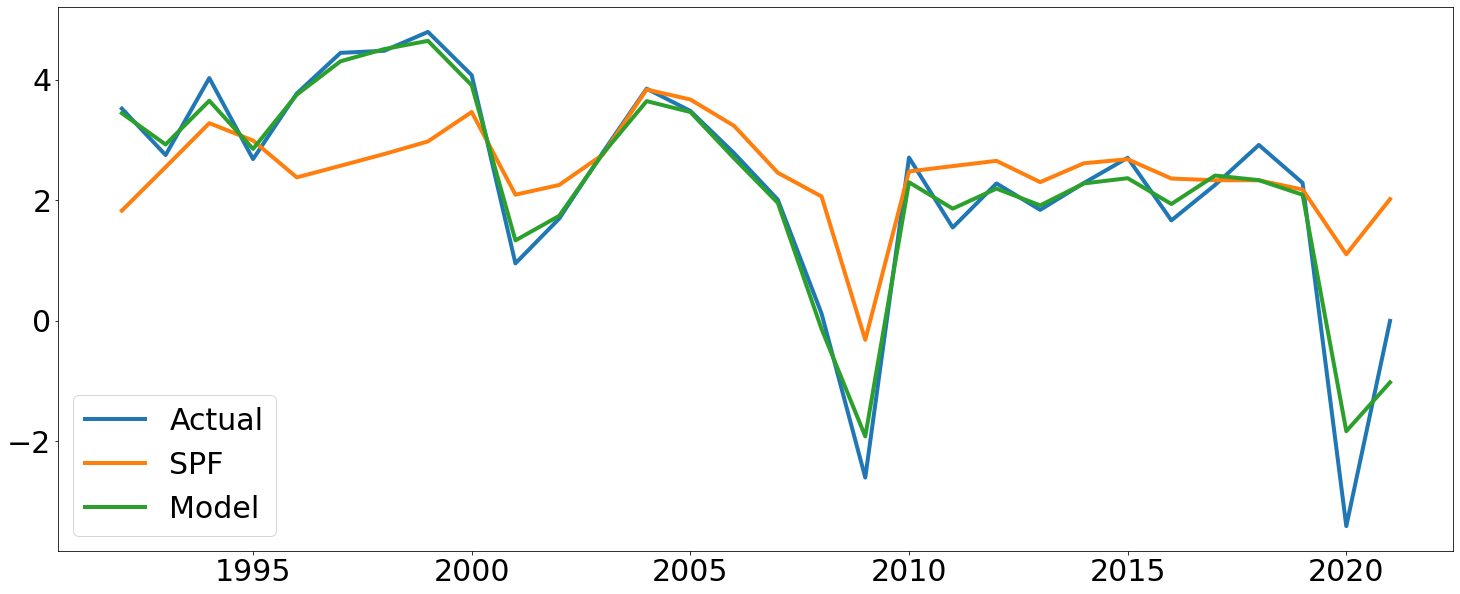

,Actual,SPF,Model
Year,,,
1992,3.52244,1.829429,3.445317
1993,2.75179,2.550978,2.926748
1994,4.02879,3.280692,3.652513
1995,2.68421,2.992412,2.852837
1996,3.77257,2.380820,3.753626
1997,4.44717,2.573348,4.306984
1998,4.48139,2.768265,4.510007
1999,4.79450,2.977600,4.646110
2000,4.07716,3.465722,3.908964


In [715]:
rf.annual_performance("Optimized","RealGDP")

In [840]:
rf_results = rf.create_results("Optimized")

In [843]:
xgb = RegressionModel("XGBoost",XGBRegressor(),True)

initial models fitted
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [54]:
xgboost.best_models = {'Unemployment': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0),
 'RealGDP': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0),
 'Core CPI': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0),
 'Core PCE': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)}

1       0.12219
2       4.48139
4      -2.59989
5       2.68421
9      -3.40459
         ...   
4625    1.66747
4627    2.28069
4630    2.75179
4631    3.77257
4633    3.48322
Name: actual, Length: 2115, dtype: float64


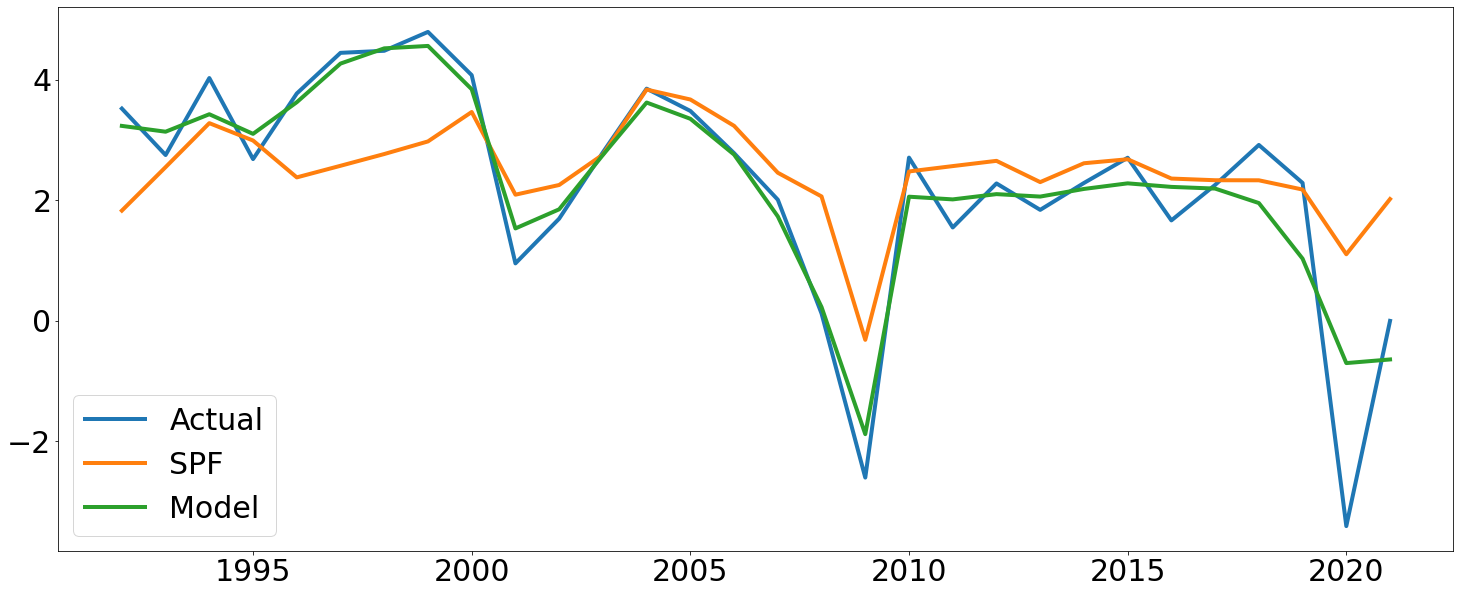

,Actual,SPF,Model
Year,,,
1992,3.52244,1.829429,3.235150
1993,2.75179,2.550978,3.138781
1994,4.02879,3.280692,3.428494
1995,2.68421,2.992412,3.103137
1996,3.77257,2.380820,3.628094
1997,4.44717,2.573348,4.269073
1998,4.48139,2.768265,4.521596
1999,4.79450,2.977600,4.561853
2000,4.07716,3.465722,3.843029


In [845]:
xgb.annual_performance("Optimized","RealGDP")

In [848]:
xg_scores = xgb.create_results("Optimized")

In [856]:
rf_test_results = rf.create_results("Optimized",test)

In [857]:
xg_test_results = xgb.create_results("Optimized",test)

In [873]:
rf_predict_results = rf.create_results("Optimized",predict)

In [874]:
xg_predict_results = xgb.create_results("Optimized",predict)

In [875]:
predict_model_predictions = pd.concat([xg_predict_results,rf_predict_results],axis=1)

In [858]:
test_model_predictions = pd.concat([xg_test_results,rf_test_results],axis=1)

In [849]:
model_predictions = pd.concat([xg_scores,rf_results],axis=1)#,lm_scores,neighbor_scores],axis=1)

In [850]:
model_predictions

,XGBoost Unemployment,XGBoost RealGDP,XGBoost Core CPI,XGBoost Core PCE,RandomForest Unemployment,RandomForest RealGDP,RandomForest Core CPI,RandomForest Core PCE
0,4.211512,-2.012987,2.071995,1.565199,5.096548,-2.302936,2.011306,1.556049
1,9.320926,4.531895,1.920452,1.514309,9.473244,4.492776,1.928142,1.498557
2,8.873712,-2.545449,1.958338,1.835796,8.654524,-2.599890,1.992068,1.859907
3,5.428789,3.159158,2.018655,1.549108,5.228887,2.837877,2.154794,1.556173
4,4.454912,1.268149,1.262077,1.703812,4.128137,1.804374,1.501677,1.651084
...,...,...,...,...,...,...,...,...
2110,NaN,2.374355,NaN,NaN,NaN,2.668563,NaN,NaN
2111,NaN,2.084629,NaN,NaN,NaN,1.929529,NaN,NaN
2112,NaN,3.032073,NaN,NaN,NaN,3.283464,NaN,NaN
2113,NaN,3.903991,NaN,NaN,NaN,3.775636,NaN,NaN


In [866]:
def create_final(df,results_df):
    t = df.loc[:,["INDICATOR","actual"]]
    initial = pd.DataFrame([])
    for measure in RegressionModel.measures:
        temp = t[t["INDICATOR"]==measure]
        temp.rename(columns={"actual":measure + " actual","INDICATOR":measure},inplace=True)
        temp.reset_index(inplace=True)
        initial = pd.concat([initial,temp],axis=1)
    initial.drop(columns = ['index'],inplace = True)
    return pd.concat([initial,results_df],axis=1)


In [870]:
val_performance = create_final(val,model_predictions)
val_performance.to_csv("../data/ValidationData/Ensemble_inputs_val.csv",index=False)

C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [871]:
test_performance = create_final(test,test_model_predictions)
test_performance.to_csv("../data/TestData/Ensemble_inputs_test.csv",index=False)

In [881]:
predict_performance=create_final(predict,predict_model_predictions)
predict_performance.to_csv("../data/PredictionData/Ensemble_inputs_predict.csv",index=False)

C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
